In [3]:
import matplotlib.pyplot as plt #importing matplotlib
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2
from IPython.display import Image
from os import listdir
from os.path import isfile, join
import pandas as pd
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

mypath = "emily-capstone-images/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

only_jpgs = [f for f in onlyfiles if f[-4:] == '.jpg']
only_jpgs = [mypath + f for f in only_jpgs]

# EDA Workshop: Understanding Images
Group 3
Amy Breden, Annie Lane, Emily Rapport, Anu Sankar

When working with images, we can think of two major categories of EDA we might want to do:

**1) EDA on the images themselves**

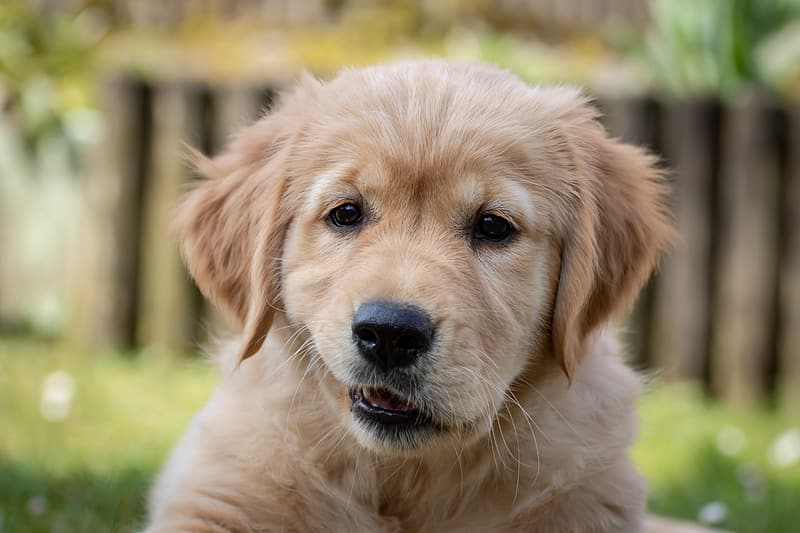

In [4]:
Image('golden-retriever-puppy-in-close-up-photography.jpg', height=300, width=400)

**2) EDA on the metadata:**

* Image name: golden-retriever-puppy-in-close-up-photography
* File extension: .jpg
* Timestamp: 8-16-2019 15:14
* Source: https://www.pikrepo.com/fdqux/golden-retriever-puppy-in-close-up-photography

### Our Team's Images

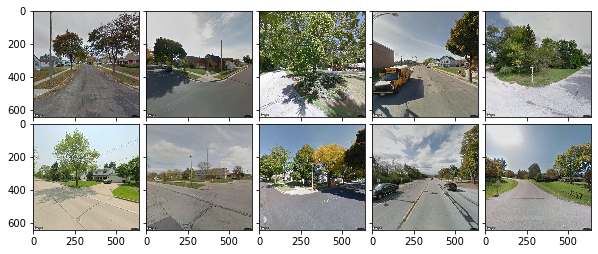

In [25]:
images = []
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(2, 5),  
                 axes_pad=0.1, 
                 )
for ax, im in zip(grid, only_jpgs[:10]):
    # Iterating over the grid returns the Axes.
    img = mpimg.imread(im)
    ax.imshow(img)
plt.show()

* 80,000 images of Milwaukee intersections
* Downloaded using Google Streetview API
* For training model that can recognize accessibility-related features

## Image Properties

**Matplotlib** and **cv2** both have methods for converting images to their pixel values and display them in various ways. 

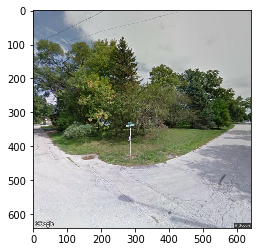

In [46]:
img_path = only_jpgs[4]
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)

In [60]:
# height, width, # of color channels
img.shape

(640, 640, 3)

In [57]:
# total number of pixels
img.size

1228800

In [69]:
# find the RGB values for a given point on image
# ex: starting from left corner, move 300 down and 5 to the right
img[300,5,:]

array([27, 54, 38], dtype=uint8)

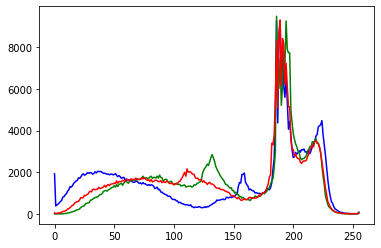

In [70]:
img = cv2.imread(img_path)
hist_by_channel = []
for i in range(3):
    histg = cv2.calcHist([img], [i], None, [256], [0,256])
    hist_by_channel.append(histg)
colors = ['b', 'g', 'r']
[plt.plot(hist, colors[i]) for i, hist in enumerate(hist_by_channel)]
plt.show()

**Questions:**
* What are other image properties might you want to look at during EDA?
* What tools/methods do you use for understanding iamges at scale?

## Image Metadata 

### Plot the age of all images using metadata

In [4]:
# Load metadata containing the year of each image and it's position
df = pd.read_csv('years.csv')
df.head()

,date,lat,long
0,2019-06,42.957503,-87.938367
1,2016-10,42.899259,-88.047098
2,2011-08,42.921614,-87.881025
3,2018-09,43.050123,-88.040263
4,2019-05,42.959289,-88.026043


#### Histogram of Images by Year Taken

In [5]:
df['year'] = [x[:4] for x in df['date']]
df_grouped = df.groupby('year').count()
df_grouped.drop(labels=['lat','long'], axis=1, inplace=True)

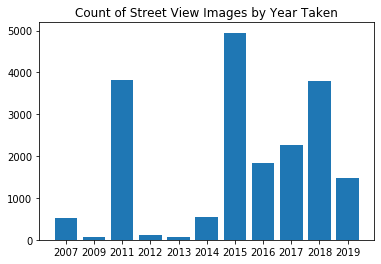

In [7]:
plt.bar(df_grouped.index, df_grouped.date)
plt.title('Count of Street View Images by Year Taken')
plt.show()

#### Geovisualization of Image Age

In [8]:
# Convert lat/long into "Point" data type
geometry = [Point(xy) for xy in zip(df["long"], df["lat"])]

In [9]:
# Convert our original DF into a GeoDF
geo_df = gpd.GeoDataFrame(df, crs = {'init': 'epsg:4326'}, geometry=geometry)
geo_df.head()

,date,lat,long,year,geometry
0,2019-06,42.957503,-87.938367,2019,POINT (-87.93836739674397 42.95750301464003)
1,2016-10,42.899259,-88.047098,2016,POINT (-88.0470983 42.8992587)
2,2011-08,42.921614,-87.881025,2011,POINT (-87.88102546135187 42.9216140449554)
3,2018-09,43.050123,-88.040263,2018,POINT (-88.04026273617674 43.05012250060103)
4,2019-05,42.959289,-88.026043,2019,POINT (-88.0260425 42.9592887)


In [10]:
# Load in shapefile containing all streets to overlay our data on
street_map = gpd.read_file('MKE_Roads/tl_2015_55079_roads.shp')

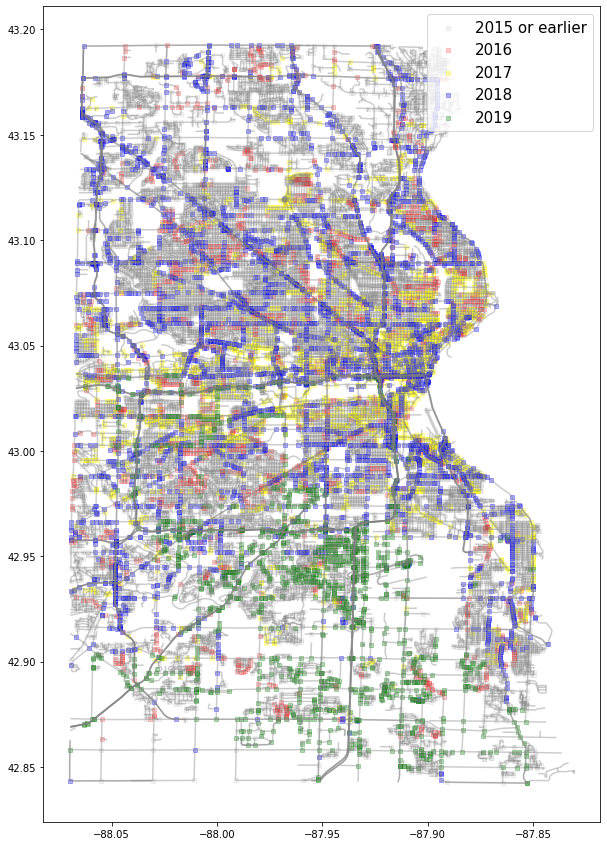

In [11]:
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.4, color='grey')
geo_df[(geo_df['year']<='2015')].plot(ax=ax, markersize=10, color='grey', alpha=0.1, marker="s", label = '2015 or earlier')
geo_df[(geo_df['year']=='2016')].plot(ax=ax, markersize=10, color='red', alpha=0.2, marker="s", label = '2016')
geo_df[(geo_df['year']=='2017')].plot(ax=ax, markersize=10, color='yellow', alpha=0.3, marker="s", label = '2017')
geo_df[(geo_df['year']=='2018')].plot(ax=ax, markersize=10, color='blue', alpha=0.3, marker="s", label = '2018')
geo_df[(geo_df['year']=='2019')].plot(ax=ax, markersize=10, color='green', alpha=0.3, marker="s", label = '2019')
plt.legend(prop={'size':15}, loc=1)
plt.show()

### Distance Between Images

In [12]:
# Using ArcGIS, can get road segment lengths and their lat/long 
road_df = pd.read_csv('Road_Lengths.csv')
road_df.head()

,OBJECTID,LINEARID,FULLNAME,RTTYP,MTFCC,Lat-Start,Long-Start,Lat-End,Long-End,Length_yd
0,2936,1.105080e+12,I- 794,I,S1100,43.032463,-87.900052,43.006165,-87.891588,3298.643801
1,6104,1.104490e+12,State Hwy 100,S,S1200,42.924585,-88.046825,42.901174,-88.039227,3063.299967
2,23330,1.104590e+11,S 116th St,M,S1400,42.896794,-88.059062,42.872647,-88.059549,2933.948585
3,3699,1.105070e+12,I- 94,I,S1100,42.982175,-87.916367,42.965809,-87.929164,2917.779699
4,18116,1.102390e+12,W County Line Rd,M,S1400,42.843580,-87.959086,42.843598,-87.991231,2873.808861


#### Histogram of length between intersections

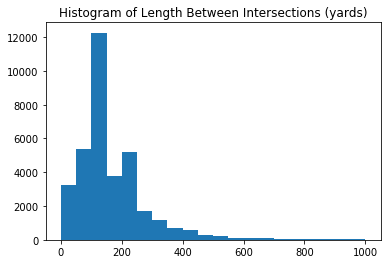

In [15]:
plt.hist(road_df.Length_yd, bins=20, range=[0,1000])
plt.title('Histogram of Length Between Intersections (yards)')
plt.show()

#### Map of Length Between Intersections

In [17]:
# Create Point features using the "start" lat/long for each segment
geometry = [Point(xy) for xy in zip(road_df["Long-Start"], road_df["Lat-Start"])]

In [19]:
# Create GeoDF from DF
geo_df = gpd.GeoDataFrame(road_df, crs = {'init': 'epsg:4326'}, geometry=geometry)
geo_df.head()

,OBJECTID,LINEARID,FULLNAME,RTTYP,MTFCC,Lat-Start,Long-Start,Lat-End,Long-End,Length_yd,geometry
0,2936,1.105080e+12,I- 794,I,S1100,43.032463,-87.900052,43.006165,-87.891588,3298.643801,POINT (-87.900052 43.032463)
1,6104,1.104490e+12,State Hwy 100,S,S1200,42.924585,-88.046825,42.901174,-88.039227,3063.299967,POINT (-88.046825 42.924585)
2,23330,1.104590e+11,S 116th St,M,S1400,42.896794,-88.059062,42.872647,-88.059549,2933.948585,POINT (-88.059062 42.896794)
3,3699,1.105070e+12,I- 94,I,S1100,42.982175,-87.916367,42.965809,-87.929164,2917.779699,POINT (-87.91636700000001 42.982175)
4,18116,1.102390e+12,W County Line Rd,M,S1400,42.843580,-87.959086,42.843598,-87.991231,2873.808861,POINT (-87.959086 42.84358)


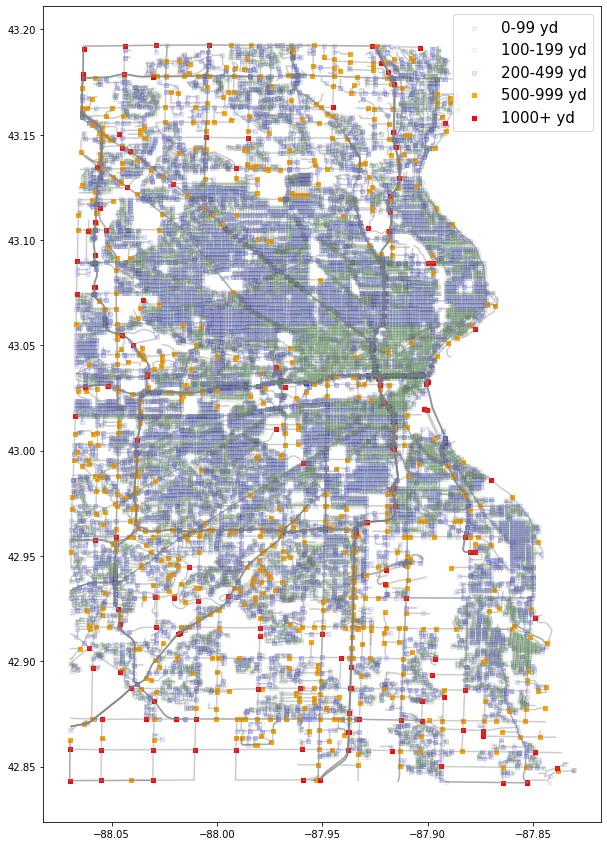

In [20]:
# Use colors to show where we may need to pull more images
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.4, color='grey')
geo_df[(geo_df['Length_yd']<100)].plot(ax=ax, markersize=10, color='grey', alpha=0.1, marker="s", label = '0-99 yd')
geo_df[(geo_df['Length_yd']>=100) & (geo_df['Length_yd']<200)].plot(ax=ax, markersize=10, color='green', alpha=0.05, marker="s", label = '100-199 yd')
geo_df[(geo_df['Length_yd']>=200) & (geo_df['Length_yd']<500)].plot(ax=ax, markersize=10, color='blue', alpha=0.1, marker="s", label = '200-499 yd')
geo_df[(geo_df['Length_yd']>=500) & (geo_df['Length_yd']<1000)].plot(ax=ax, markersize=10, color='orange', alpha=1, marker="s", label = '500-999 yd')
geo_df[(geo_df['Length_yd']>=1000)].plot(ax=ax, markersize=10, color='red', alpha=1, marker="s", label = '1000+ yd')

plt.legend(prop={'size':15}, loc=1)
plt.show()

**Questions**

* What other image metadata would you investigate during EDA?
* How would you address the older images in the dataset given that they don't appear to be clustered?